# Pipeline de Segmentació de Teixits Cerebrals en Imatges de Ressonància Magnètica

Aquesta pipeline representa els diferents passos a dur a terme per segmentar els diferents teixits cerebrals d'una ressonància magnètica. Aquesta segmentació es pot realitzar de diverses maneres i es poden utilitzar diversos mètodes. En aquest cas, aquesta pipeline fa referència a una de les maneres que he trobat òptima i bàsica per realitzar aquesta segmentació. 

A través d'aquesta pipeline, l'objectiu és realitzar la segmentació de diferents teixits a partir d'imatges de ressonància magnètica cerebral, amb l'objectiu final d'obtenir tres tipus de teixits clarament diferenciats: la Substància Blanca, la Substància Grisa i el Líquid Cefalorraquidi.
Per aconseguir-ho, s'emprarà l'algoritme de Region Growing com a tècnica de segmentació manual. Això significa que realitzarem la segmentació de manera manual sense dependre de cap llibreria específica, implementant l'algoritme de Region Growing mitjançant el nostre propi codi personalitzat.

També es realitzarà una altra segmentació utilitzant l'algoritme K-means, però en aquest cas es farà amb l'ajuda d'una llibreria de Python específica. En lloc d'implementar l'algoritme directament, s'utilitzarà una llibreria ja existent per realitzar aquest procés de segmentació automàticament.

La realització d'aquestes dues segmentacions té com a finalitat comparar els resultats obtinguts mitjançant les dues aproximacions diferents, la qual cosa permetrà avaluar la consistència i la precisió de la segmentació manual enfront de la segmentació automàtica. 

La pipeline inclou nou passos a seguir per acabar obtenint com a resultat la segmentació d'interès:

1. Extracció del crani
2. Adquisició i lectura de dades
3. Preparació de dades
4. Caracterització dels teixits
5. Segmentació manual mitjançant Region Growing
6. Segmentació automàtica mitjançant K-means
7. Validació i avaluació dels resultats
8. Preparació de dades resultants per a la visualització
9. Visualització dels resultats

Les dades amb les quals treballarem consisteixen en cinc casos de ressonància magnètica cerebral de pacients, emmagatzemats en una carpeta que es gestionarà durant el desenvolupament de la pipeline. Cada cas consta de tres arxius: T1, T2_FLAIR i LabelsForTesting. En el procés de la pipeline, farem servir l'arxiu T1, ja que aquest conté la ressonància magnètica que ha de ser segmentada. L'arxiu LabelsForTesting, que actua com a Ground Truth i conté els resultats de segmentació correctes, s'utilitzarà per validar i avaluar les segmentacions.

## 1. Extracció del crani

A part del cervell, l'arxiu de ressonància magnètica cerebral també inclou altres components com el crani i altres estructures. Amb la finalitat de segmentar el cervell, és necessari eliminar el crani de les imatges de ressonància (T1) de cada cas. Per aconseguir això, farem servir una eina anomenada "Robust Brain Extraction" (ROBEX), que ens permetrà obtenir la mateixa imatge de ressonància, però sense el crani. Aquesta imatge resultant tintrà nom MRI_SENSE_CRANI i serà utilitzada com a entrada per al procés de segmentació posterior. Aquesta es guardarà en la carpeta del cas al qual correspon. 

Instal·lem ROBEX desde la seva pàgina oficial i utilitzem l'eina per extreure el cervell:
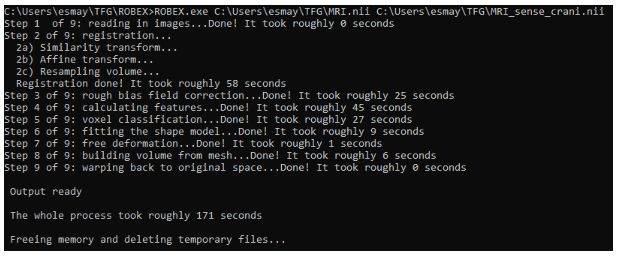

Primerament, abans de procedir amb les següents etapes, instal·lem les llibreries requerides i definim i creem les funcions necessàries amb antelació.

LLIBRERIES

In [50]:
import cv2 # processament i anàlisis d'imatges 
import numpy as np # processament numèric i manipulació de dades
from sklearn.cluster import KMeans # l'ús de l'algortime k-means 
import SimpleITK as sitk # processament i anàlisis d'imatges médiques
import time # mesura del temps de part de programa 
import os # treballar amb carpetes

FUNCIONS

In [51]:
def INTENSITATS_IMATGE (imatge):
    """Obté les intensitats dels píxels que no son fons d'una imatge i les guarda en un vector.
    
    Parameters
    ----------
    imatge : matriu
        Imatge en format matriu que representa una llesca de la ressonància
        
    Returns 
    -------
    vector
        Vector que conté tots els valors d'intensitat dels píxels de la imatge que no són fons
    """
    
    #Creem el vector on guadarem les intensitats corresponents
    intensitats = []
    
    # Recorrem la imatge
    for x in range(imatge.shape[0]):
        for y in range(imatge.shape[1]):
            
            # Descartem els pixels que són fons
            if imatge[x][y] != 0:
                
                # Afegim la intensitat al vector
                intensitats.append(imatge[x][y])
                
    return intensitats

In [52]:
def CLASSIFICACIO_INTENSITATS_KMEANS (carac):
    """Classifica les dades de la matriu de característiques en tres classes realitzant l'algoritme K-means (0, 1, 2)
    
    Parameters
    ----------
    carac : matriu
        Matriu de característiques d'una imatge (llesca)
        
    Returns 
    -------
    vector
        Vector que conté les etiquetes numèriques assignades per l'algoritme K-means a les dades de la matriu de característiques
    """
    
    # Creem el model de K-means amb k = 3 
    kmeans = KMeans(n_clusters=3, random_state=0, n_init=10)

    # Ajustem el model a les dases
    kmeans.fit(carac)

    # Obtim les etiquetes de classificació
    etiquetes = kmeans.labels_
    
    return etiquetes

In [53]:
def CALCUL_ESTADISTICS (classe):
    """Calcula la mitjana i la desviació estàndard d'un conjunt de dades que representen una classe/regió
    
    Parameters
    ----------
    classe : vector
        Vector que conté els valors d'intensitat dels píxels que formen part de la classe/regió tractant
        
    Returns 
    -------
    vector
        Vector que conté els dos estadístics calculats
    """
    # Calculem els estadístics
    mitjana = np.mean(classe)
    desv = np.std(classe)
    
    # Guardem els estadístics 
    estadistics = [mitjana, desv]
    
    return estadistics

In [54]:
def REGIO_PERTANY(pixel, carac):
    """Classifica el píxel en una de les regions de la imatge de manera similar a l'algortime del veí més proper: calcula la
    diferència entre el valor de la intensitat del píxel i la intensitat mitjana del píxel de cada regió, el píxel pertany 
    a la regió on la diferència és la més petita. 
    
    Parameters
    ----------
    pixel : valor float
        Valor de la intensitat del píxel
    
    carac: llista
        Llista que conté les característiques (mitjana i desviació) de cada regió 
          
    Returns 
    -------
    int
        Valor de la posició en la llista carac de la regió a la qual pertany el píxel
    """
    
    # Inicialitzem variables necessàries
    dif_minim = float('inf')  # 'inf' per assegurar que qualsevol diferència sigui menor
    pos = -1 
    
    # Trobem la posició en la matriu carac on la diferència del píxel i el les característiques de la regió sigui mínima
    for i, regio in enumerate(carac):
        
        dif = abs(regio[0] - pixel)
        if dif < dif_minim:
            
            dif_minim = dif
            pos = i
    
    return pos

In [55]:
def ETIQUETAR_LLAVOR (pos_x, pos_y, imatge, etiquetes, veins, features):
    """Etiqueta el píxel llavor de la posició (pos_x, pos_y) de la imatge i l'afegeix al vector veïns per consultar els seus 
    veïns i fer crèixer la regió de la llavor
    
    Parameters
    ----------
    pos_x : int
        Posició en l'eix X del píxel llavor que consultem
        
    pos_y : int
        Posició en l'eix Y del píxel llavor que consultem
        
    imatge: matriu
        Imatge que correspon a una llesca de la ressonància magnètica cerebral
        
    etiquetes: matriu
        Matriu que guarda les etiquetes de cada píxel durant el creixement de regions
        
    veins: vector
        Vector que guardar les coordenades dels píxels que s'han de consultar els seus veïns per crèixer la regió
        
    features: llista
        Llista que conté les característiques (mitjana i desviació) de cada regió
        
    Returns 
    -------
    int
        Valor de la posició en la llista features de la regió a la qual pertany el píxel
    """

    # Determinem la regió a la qual pertany la llavor (fem que sigui una unitat més gran perquè no volem etiquetes de valor 0)
    regio = REGIO_PERTANY(imatge[pos_x][pos_y], features) + 1
    
    # Etiquetem la llavor 
    etiquetes[pos_x][pos_y] = regio

    # Guardem les coordenades de la llavor al vector veïns per consultar els seus veïns si també formen part de la regió
    veins.append([pos_x,pos_y])
    
    return regio

In [56]:
def CONSULTAR_VEI (pos_x, pos_y, imatge, etiquetes, regio, veins, factor):
    """Consulta i etiqueta el píxel veí de la posició (pos_x, pos_y). El píxel obté etiqueta si forma part de la regió creixent
    segons les seves característiques.
    
    Parameters
    ----------
    pos_x : int
        Posició en l'eix X del píxel que consultem
        
    pos_y : int
        Posició en l'eix Y del píxel que consultem
        
    imatge: matriu
        Imatge que correspon a una llesca de la ressonància magnètica cerebral
        
    etiquetes: matriu
        Matriu que guarda les etiquetes de cada píxel durant el creixement de regions
        
    regio: int
        Valor de l'etiqueta de la regió creixent (cada regió té una etiqueta/número)
        
    veins: vector
        Vector que guardar les coordenades dels píxels que s'han de consultar els seus veïns per crèixer la regió
    
    factor : float
        Valor del paràmetre que ajusta el rang d'acceptació dins la regió
    """
    
    # Consultem que forma part de la regió
    if etiquetes[pos_x, pos_y] == 0 and imatge[pos_x][pos_y] != 0 and features[regio-1][0] - factor * features[regio-1][1] <= imatge[pos_x][pos_y] <= features[regio-1][0] + factor * features[regio-1][1]:
 
        # Etiquetem i afegim píxel a la regió
        etiquetes[pos_x][pos_y] = regio
        
        # Afegim al vector veins per consultar els seus veins 
        veins.append([pos_x,pos_y])

In [57]:
def REGIO_PERTANY_KMEANS (imatge, etiquetes, regio, features):
    """Determina a quin teixit pertany la regió classificada amb etiqueta 'regió' per l'algoritme k-means.
    
    Parameters
    ----------
    imatge : matriu 
        Imatge que correspon a una llesca de la ressonància magnètica cerebral
    
    etiquetes : matriu
        Matriu que guarda les etiquetes de cada píxel durant el creixement de regions

    regio: int
        Valor de l'etiqueta de la regió que volem ajustar la seva etiqueta (intensitat) 
        
    features : llista
        Llista que conté les característiques (mitjana i desviació) de cada regió 
    """
    
    # Obtenim els píxels de la imatge que tenen el valor 'regio' 
    pixels_regio = imatge[etiquetes == regio]

    # Calculem la mitjana dels valores de intensitat dels píxels amb etiqueta 'regio'
    mitjana = np.mean(pixels_regio)
    
    # Determinem el teixit al qual pertany l'etiqueta 'regio'
    teixit = REGIO_PERTANY(mitjana, features) + 1
    
    return teixit


In [58]:
def AJUSTAMENT_ETIQUETES_KMEANS (imatge, etiquetes, features, mida):
    """Ajusta les etiquetes de les regions trobades per l'algorITme k-means, ja que l'algoritme K-means classifica els 
    píxels de cada llesca de la ressonància però no dóna la mateixa etiqueta d'una mateixa regió a totes les llesques.
    
    Parameters
    ----------
    imatge : matriu 
        Imatge que correspon a una llesca de la ressonància magnètica cerebral
    
    etiquetes : matriu
        Matriu que guarda les etiquetes de cada píxel durant els creixement de regions
        
    features : llista
        Llista que conté les característiques (mitjana i desviació) de cada regió 
    """
    # Identifiquem a quin teixit pertany cada etiqueta 
    r1 = REGIO_PERTANY_KMEANS (imatge, etiquetes, 1, features)
    r2 = REGIO_PERTANY_KMEANS (imatge, etiquetes, 2, features)
    r3 = REGIO_PERTANY_KMEANS (imatge, etiquetes, 3, features)
     
    # Canviem i ajustem els valors de les etiquetes als corresponents
    for x in range(mida[2]):
        for y in range(mida[1]):
            if etiquetes[x,y] == 1:
                etiquetes[x,y] = r1
            elif etiquetes[x,y] == 2:
                etiquetes[x,y] = r2
            elif etiquetes[x,y] == 3:
                etiquetes[x,y] = r3

In [59]:
def DICE_3D (volum_coincidencies, volum_manual, volum_real):
    """Calcula la mesura de similitud (dice) volumètrica
    
    Parameters
    ----------
    volum_coincidencies : int
        volum/nombre de píxels/vòxels que coincideixen en la intersecció de la segmentació manual i el k-means 
    
    volum_manual : int
        volum/nombre de píxels/vòxels que que componen la segmentació manual
        
    volum_kmeans : int
        volum/nombre de píxels/vòxels que que componen la segmentació k-means
        
    Returns 
    -------
    float
        Valor entre 0 i 1 que indica la similitud entre dues segmentacions
    """
    return (2 * volum_coincidencies) / (volum_manual + volum_real)

In [60]:
def DICE_SCORE_TOT_ARXIU (segmentacio, truth, mida):
    """Troba els paràmetres necessaris i calcula el coeficient DICE 3D entre dues segmentacions: segmnetacio i truth. 
    
    Parameters
    ----------
    segmentacio : matriu
        Matriu amb les llesques segmentades com a contingut
    
    truth : matriu
        Matriu amb les llesques amb la segmentació correcta com a contingut
    
    mida : vector
        Vector que conté la mida dels arxius 
        
    Returns 
    -------
    float
        Valor entre 0 i 1 que indica la similitud entre la segmentació i el truth
    """
    # Inicialitzem variables necessàries
    coincidencies = 0
    volum_manual = 0
    volum_real = 0
    
    for ll in range(mida[0]):
        # Creem màscara per determinar els píxels de la intersecció de les dues imatges
        mask= np.zeros((mida[2], mida[1]), dtype=np.float64)
        
        # Trobem i determinem les coincidències
        mask[np.logical_and(segmentacio[ll,:,:] == truth[ll,:,:], segmentacio[ll,:,:] != 0)] = 1
        coincidencies = coincidencies + np.count_nonzero(mask==1)
        
        # Determinem les altres variables
        volum_manual = volum_manual + np.count_nonzero(segmentacio[ll,:,:])
        volum_real = volum_real + np.count_nonzero(truth[ll,:,:])
    
    # Calculem el coeficient DICE amb les variables trobades
    return DICE_3D(coincidencies, volum_manual, volum_real)

In [61]:
def DICE_SCORE_REGIO (valor, segmentacio, truth, mida):
    """Troba els paràmtres necessaris i calcula el coeficient DICE 3D d'una regió en dues segmentacions: segmnetacio i truth. 
    
    Parameters
    ----------
    valor : int
        Valor de l'etiqueta que té la regió que es vol calcular la similitud entre les dues segmentacions
        
    segmentacio : matriu
        Matriu amb les llesques segmentades com a contingut
    
    truth : matriu
        Matriu amb les llesques amb la segmentació correcta com a contingut
    
    mida : vector
        Vector que conté la mida dels arxius 
        
    Returns 
    -------
    float
        Valor entre 0 i 1 que indica la similitud de la regió segmentada entre la segmentació i el truth
    """
    # Inicialitzem variables necessàries
    coincidencies = 0
    volum_manual = 0
    volum_real = 0

    for ll in range(mida[0]):
        # Creem màscara per determinar els píxels de la intersecció de les dues imatges d'una regió
        mask= np.zeros((mida[2], mida[1]), dtype=np.float64)
        
        # Trobem i determinem les coincidències d'una regió
        mask[np.logical_and(segmentacio[ll,:,:] == truth[ll,:,:], segmentacio[ll,:,:] == valor)] = 1
        coincidencies = coincidencies + np.count_nonzero(mask == 1)
        
        # Determinem les altres variables
        volum_manual = volum_manual + np.count_nonzero(segmentacio[ll,:,:] == valor)
        volum_real  = volum_real + np.count_nonzero(truth[ll,:,:] == valor)
        
    # Calculem el coeficient DICE amb les variables trobades
    return DICE_3D(coincidencies, volum_manual, volum_real)

In [62]:
def MATRIU_CONCURRENCIA (imatge1, imatge2, etiquetes):
    """Calcula els quatre elements de la matriu de concurrència.
    
    Parameters
    ----------
    imatge1 : matriu
        Imatge en format de matriu que correspon a una llesca d'una segmentació
        
    imatge2 : matriu
        Imatge en format de matriu que correspon a una llesca d'una altra segmentació
    
    etiqueta: int
        Valor que correspon a l'etiqueta que té la regió que es vol avaluar
        
    Returns 
    -------
    matriu
        matriu amb el contingut dels seus quatre elements en el següent format: 
                                                  TP  FP 
                                                (        )
                                                  FN  TN
    """
    # Creem les matrius binàries del tipus booleà 
    etiquetes1 = np.zeros_like(imatge1, dtype=np.bool_)
    etiquetes2 = np.zeros_like(imatge2, dtype=np.bool_)
    etiquetes3 = np.zeros_like(imatge1, dtype=np.bool_)
    etiquetes4 = np.zeros_like(imatge2, dtype=np.bool_)
    
    # Calculem i determinem els quatre elements: TP, FN, TN, FP
    for etiqueta in etiquetes:
        etiquetes1[imatge1 == etiqueta] = True
        etiquetes2[imatge2 == etiqueta] = True
        etiquetes3[imatge1 != etiqueta] = True
        etiquetes4[imatge2 != etiqueta] = True
    
    TP = np.sum(np.logical_and(etiquetes1, etiquetes2))
    FN = np.sum(np.logical_and(etiquetes1, np.logical_not(etiquetes2)))
    TN = np.sum(np.logical_and(etiquetes3, etiquetes4))  
    FP = np.sum(np.logical_and(etiquetes3, np.logical_not(etiquetes4))) 
    
    # Creem la matriu de concurrència
    concurrencia = [
        [TP, FP],
        [FN, TN]
    ]
    
    return concurrencia

In [63]:
def SENSIBILITAT_LLESCA(TP, FN, etiqueta):
    """Calcula la sensibilitat de dues imatges (llesques).
    
    Parameters
    ----------
    TP : int
        Nombre de True Positive entre dues imatges
        
    FN : matriu
        Nombre de False Negative entre dues imatges
    
    etiqueta: int
        Valor que correspon a l'etiqueta que té la regió que es vol avaluar
        
    Returns 
    -------
    float
        Valor entre 0 i 1 que indica la sensibilitat entre aquestes dues llesques.
    """
    
    # Calculem la sensibilitat tenint en compte que hi ha llesques que no tenen secció de cervell i pot donar 0
    if TP + FN == 0:
        sensibilitat = 0.0  
    else:
        sensibilitat = TP / (TP + FN)
    
    return sensibilitat

In [64]:
def PRECISIO_LLESCA(TP, FP, etiqueta):
    """Calcula la precisió de dues imatges (llesques).
    
    Parameters
    ----------
    TP : int
        Nombre de True Positive entre dues imatges
        
    FP : matriu
        Nombre de False Positive entre dues imatges
    
    etiqueta: int
        Valor que correspon a l'etiqueta que té la regió que es vol avaluar
        
    Returns 
    -------
    float
        Valor entre 0 i 1 que indica la precisió entre aquestes dues llesques.
    """  
    
    # Calculem la precisió tenint en compte que hi ha llesques que no tenen secció de cervell i pot donar 0
    if TP + FP == 0:
        precisio = 0.0  
    else:
        precisio = TP / (TP + FP)
    
    return precisio

In [65]:
def ESPECIFICITAT_LLESCA (TN, FP, etiqueta):
    """Calcula l'especificitat de dues imatges (llesques).
    
    Parameters
    ----------
    TN : int
        Nombre de True Negative entre dues imatges
        
    FP : matriu
        Nombre de False Positive entre dues imatges
    
    etiqueta: int
        Valor que correspon a l'etiqueta que té la regió que es vol avaluar
        
    Returns 
    -------
    float
        Valor entre 0 i 1 que indica l'especificitat entre aquestes dues llesques.
    """
    
    # Calculem l'especificitat tenint en compte que hi ha llesques que no tenen secció de cervell i pot donar 0
    if TN + FP == 0:
        especificitat = 0.0  
    else:
        especificitat = TN / (TN + FP)
    
    return especificitat

In [66]:
def METRICA (arxiu1, arxiu2, etiqueta, num_llesques, concurrencia, lletra):
    """Calcula la  mètrica d'avaluació especificada pel paràmetre lletra entre els dos arxius. ('s'-sensibilitat, 'p'-precisió, 'e'-especificitat)
    
    Parameters
    ----------
    arxiu1 : matriu
        Imatges en format de matriu tridimensional que correspon a la ressonància obtinguda d'una segmentació
        
    arxiu2 : matriu
        Imatges en format de matriu tridimensional que correspon a la ressonància obtinguda d'una altra segmentació
        
    Returns 
    -------
    float
        Valor entre 0 i 1 que indica la mètrica calculada entre dues segmentacions.
    """
    
    # Inicialitzem les variables
    total = 0
    n = 0
    
    # Recorrem cada llesca i calculem la sensibilitat
    for ll in range(num_llesques):
        if lletra == 's':
            r = SENSIBILITAT_LLESCA(concurrencia[0][0], concurrencia[1][0], etiqueta)
        elif lletra == 'p':
            r = PRECISIO_LLESCA(concurrencia[0][0], concurrencia[0][1], etiqueta)
        else: 
            r = ESPECIFICITAT_LLESCA(concurrencia[1][1], concurrencia[0][1], etiqueta)
            
        if r != 0:
            total = total + r
            n = n + 1
    
    # Calculem la sensibilitat total
    resultat = total / n
    
    return resultat

In [67]:
def CONVERSIO_ARXIU_PER_GUARDAR (v, arxiu_original):
    """Converteix un vector que emmagatzema imatges en un arxiu del format .nii
    
    Parameters
    ----------
    v : vector
        Vector que conté les llesques de la ressonància segmentades 
    
    arxiu_original : .nii
        Arxiu de la ressonància magnètica original
        
    Returns 
    -------
    .nii
        Arxiu en el mateix format i capçalera que l'arxiu original que conté les llesques segmentades corresponents
    """

    # Convertim la matriu de tipus uint8 a una matriu de tipus float
    arxiu_float = v.astype(np.float32) 

    # Convertim la matriu de tipus float a una imatge de SimpleITK
    arxiu_sitk = sitk.GetImageFromArray(arxiu_float)
    
    # Afegim la capçalera del arxiu original
    arxiu_sitk.CopyInformation(arxiu_original)
    
    return arxiu_sitk

## 2. Adquisició i lectura de dades

Les dades es troben en la carpeta *mrbrains* que conté els 5 casos de ressonàncies magnètiques de pacients diferents. Preparem la lectura de dades en la qual s'ha d'especificar quin cas es vol tractar especificant un número de l'1 fins al 5. Les dades que es llegiran seran l'arxiu obtingut en l'etapa d'extracció del crani i l'arxiu *LabelsForTesting (Ground Truth)*. 

In [68]:
# Especifiquem la ruta de la carpeta "mrbrains" que conté les ressonàncies dels pacients
carpeta_mrbrain = "mrbrains"

# Determinem la ruta de la carpeta d'un cas especificant el número corresponent
carpeta = os.path.join(carpeta_mrbrain, "1")

# Ruta completa del cas que volem tractar
ruta = os.path.join(carpeta, "MRI_sense_crani.nii")

In [69]:
# Llegim la ressonància del cas especificat
ressonancia = sitk.ReadImage(ruta)

In [70]:
# Llegim el Ground Truth
truth = sitk.ReadImage(os.path.join(carpeta, "LabelsForTesting.nii"))

## 3. Preparació de dades

Les dades llegides no estan preparades per poder tractar-les i processar-les, per això en aquest pas apliquem algunes conversions en les dades.

Preparem l'arxiu a segmentar:

In [71]:
# Convertim l'arxiu en una matriu
ressonancia_np = sitk.GetArrayFromImage(ressonancia)
    
#Convertim a double per poder fer càlculs amb precisió
ressonancia_preparada = ressonancia_np.astype(np.float64)

Preparem l'arxiu per més endavant poder avaluar els resultats:

In [72]:
# Convertim l'arxiu en una matriu 
truth_np = sitk.GetArrayFromImage(truth)
    
#Convertim a double per poder fer càlculs amb precisió
truth_preparada = truth_np.astype(np.float64)

## 4. Caracteristació de teixits

Ara que ja podem analitzar l'arxiu, comencem extraient les característiques de cada teixit que volem segmentar. Ens centrem en una sola característica: la intensitat. De cada teixit obtenim la mitjana i la desviació estàndard de les intensitats dels píxels que formen part de cada teixit. Aquestes dues variables són les característiques que tindrem com a referència per classificar les regions que trobem en les imatges.
Les característiques les obtenim d'una sola llesca de la ressonància, aquesta correspon a una llesca central. Explorant la ressonància s'ha observat que en les llesques centrals, en general, els tres teixits es troben en la seva màxima expansió en l'àrea, per la qual són bones llesques per obtenir la màxima informació possible i determinar les característiques de cada teixit. D'una ressonància magnètica s'obtenen 48 llesques del cervell, per això escollim com a llesca de referència la llesca número 25. 
Per obtenir les característiques de cada teixit, comencem seleccionant tots els píxels que no són fons. Aquests píxels els dividim en tres classes i per a cada classe calculem la mitjana i la desviació estàndard, que seran les característiques de cada teixit. Aquestes característiques es guarden en un vector en ordre ascendent, de manera que puguem identificar les característiques de cada teixit en l'ordre següent: líquid cefalorraquidi, substància gris i substància blanca. Sabent que el líquid és el teixit amb la intensitat més baixa i la substància blanca és la que té la intensitat més alta, les seves mitjanes també seguiran el mateix patró. En ordenar el vector segons les mitjanes, obtenim l'ordre desitjat de les característiques.

In [73]:
# Guardem la llesca de referència
referencia = ressonancia_preparada[25,:,:]

In [74]:
# Obtenim els valors d'intensitats de la llesca que no són fons
intensitats = INTENSITATS_IMATGE(referencia)

# Convertim les intensitats en una matriu de característiques 
matriu_carc = [[valor] for valor in intensitats]

# Classifiquem en tres clases les intensitats
classes = CLASSIFICACIO_INTENSITATS_KMEANS(matriu_carc)

In [75]:
# Diferenciem i emmagatzemem els píxels (intensitats) en diferents vectors segons la seva classe
classe1 = []
classe2 = []
classe3 = []

for valor, classe in zip(intensitats, classes):
    if classe == 0:
        classe1.append(valor)
    elif classe == 1:
        classe2.append(valor)
    else:
        classe3.append(valor)

In [76]:
# Calculem els estadístics de cada classe
estadistics1 = CALCUL_ESTADISTICS(classe1)
estadistics2 = CALCUL_ESTADISTICS(classe2)
estadistics3 = CALCUL_ESTADISTICS(classe3)

In [77]:
# Guardem els estadístics de totes les classes
features = [estadistics1, estadistics2, estadistics3]

# Ordenem les característiques en orde ascendent segons la mitjana (x[0]): liquid, materia gris i materia blanca
features = sorted(features, key=lambda x: x[0])

## 5. Segmentació manual mitjançant Region Growing

Una vegada tenim l'arxiu llest per processar-lo i les característiques que ens permetran classificar els diferents teixits, ja podem passar a efectuar la segmentació manual. La segmentació manual es realitza mitjançant l'algoritme *Region Growing*. Aquest algoritme el codificarem manualment adaptant-ho a les nostres dades. Per tractar amb l'arxiu ho fem processant individualment cada llesca com una imatge. Per cada llesca, comencem descartant els píxels que corresponen a fons perquè aquests no intervinguin durant el creixement de regions. Seguidament, seleccionem una llavor, la classifiquem i l'etiquetem segons les seves característiques mitjançant la matriu *features*. Un cop sabem a quin teixit pertany la llavor, fem créixer la regió consultant els veïns si corresponen al mateix teixit. El criteri d'acceptació d'un píxel per formar part de la regió creixent és determinat per un paràmetre anomenat *factor*, aquest crea el rang en el qual s'han de trobar les característiques del píxel que consultem per acceptar-lo en la regió. El rang d'acceptació es determina de la següent manera: *mitjana +- factor x desviació estàndard*. Així successivament es consulten els píxels veïns fins que la regió no trobi més per afegir a la regió i acabi la seva expansió. Aquest procediment es realitza reiteradament fins que s'hagin estès totes les regions de la llesca. El procediment s'efectua per cada llesca de la ressonància.

Creem i inicialitzem les variables necessàries per aquest pas:

In [78]:
# Obtenim i guardem les dimensions de la ressonància
mida = ressonancia_preparada.shape

X_mida = mida[2]
Y_mida = mida[1]
Z_mida = mida[0] # nombre de llesques

In [79]:
# Inicialitzem una matriu de la mateixa mida que les dades, on guardarem les segmentacions resultants de les llesques
processat = np.zeros_like(ressonancia_preparada)

In [80]:
# Inicialitzem el nombre de llesques tractades
num_llesca = 0

In [81]:
# Inicializem el temps inicial de la segmentació manual
iniciGrowing = time.time()

In [82]:
# Asigmen el valor òptim del paràmetre que ajusta el rang d'acceptació per considerar que un píxel forma part d'una regió
factor = 2.4

In [83]:
# Recorrem cada llesca i apliquem l'algoritme Region Growing classificant les regions en els diferents teixits
for ll in range(Z_mida):
    
    # Actualitzem el número de la llesca tractant
    num_llesca = num_llesca + 1
    print(f"Número llesca {num_llesca}", end='\r')
    
    # Obtenim una llesca
    llesca = ressonancia_preparada[ll,:,:]
    
    # Comprovem que la llesca no és fons i té part de cervell a segmentar
    if not np.all(llesca == 0):

        # Creem una matriu de zeros amb la mateixa mida que la imatge on guardarem les etiquetes (regió a la qual pertany) de cada píxel
        etiquetes = np.zeros((X_mida, Y_mida), dtype=np.float64)

        # Inicialitzem el vector on es guardaràn els píxels a consultar els seus veïns 
        veins = [] 

        # Etiquetem tots els píxels que són fons en la matriu etiquetes per no tenir-los en compte en el creixement de regions
        etiquetes[llesca == 0] = 4 
        
        # Busquem els píxels que no tinguin etiqueta (aquests corresponen a píxels que encara s'han de fer crèixre la regió i classificar)
        zeros = np.where(etiquetes == 0)
        
        # El creixement de regions es duu a terme mentre hi hagi píxels sense etiquetar, per això aquest bucle s'efectua mentres trobi píxels sense etiqueta
        while zeros[0].size > 0:
            
            # Obtenim la posició d'un píxel que ha trobat sense etiqueta, aquest serà la llavor de la regió que fem crèixre
            x = zeros[0][0]
            y = zeros[1][0]
            
            # Determinem la regió a la qual pertany la llavor i que farem crèixre
            regio = ETIQUETAR_LLAVOR(x, y, llesca, etiquetes, veins, features)

            # La regió creix mentre trobi píxels a consultar veïns en el vector VEÏNS que aquest es va actualitzant a mesura que s'afegeixen píxels a la regió
            while veins: 
                
                # Accedim per ordre als pixels guardats a la llista VEÏNS agafant l'últim del vector
                pixel = veins.pop()
                
                #Guardem les seves coordenades
                xx = pixel[0]
                yy = pixel[1]

                # Consultem els seus veins fent connectivitat A4
                #DRETA, x+1
                if xx+1 < X_mida:
                    CONSULTAR_VEI (xx+1, yy, llesca, etiquetes, regio, veins, factor)

                # ESQUERRA, x-1
                if xx-1 >= 0:
                    CONSULTAR_VEI (xx-1, yy, llesca, etiquetes, regio, veins, factor)

                # ADALT, y+1
                if yy+1 < Y_mida:
                    CONSULTAR_VEI (xx, yy+1, llesca, etiquetes, regio, veins, factor)

                # ABAIX, y-1
                if yy-1 >= 0:
                    CONSULTAR_VEI (xx, yy-1, llesca, etiquetes, regio, veins, factor)
            
            # Ha acabat el creixement de la regió trobada arribant a la seva expansió màxima
            # Busquem píxels sense etiqueta per seleccionar una altra llavor i fer crèixre una altra regió
            zeros = np.where(etiquetes == 0)

        # Ajustem el fons a intensitat 0 en la matriu d'etiquetes al acabar la segmentació, ja que durant el region growing no podia haver-hi etiquetes 0
        etiquetes[etiquetes == 4] = 0
        
    else: # La llesca no conté cervell, només és fons
        # No hi ha part de cervell a segmentar per tant totes les etiquetes de la llesca són 0
        etiquetes = np.zeros((X_mida, Y_mida), dtype=np.float64)
            
    # Guardem la segmentació de la llesca
    processat[ll,:,:] = etiquetes

In [84]:
# Guardem el temps final de la segmentació manual
finGrowing = time.time()

In [85]:
# Calculem el temps transcurregut en la segmentació manual
tempsGrowing = finGrowing - iniciGrowing

## 6. Segmentació automàtica mitjançant K-means

A aquest punt, ja disposem de la segmentació manual del cas completada. En aquesta etapa, apliquem la segmentació automàtica utilitzant l'algorisme K-means amb l'ajuda de la biblioteca "sklearn.cluster (KMeans)". Aquest procés implica tractar cada llesca com una imatge i aplicar l'algorisme de segmentació. Un cop s'ha completat la segmentació de la llesca, ajustem les intensitats de les regions segmentades perquè coincideixin amb les de la segmentació manual. Aquesta concordança ens permetrà, com ja hem esmentat anteriorment, comparar i avaluar els resultats de la segmentació manual amb els de la segmentació automàtica.

Comencem declarant i inicialitzant les variables necessàries per la segmentació automàtica:

In [86]:
# Inicialitzem una matriu de la mateixa mida que les dades on guardarem les segmentacions de les llesques
processat_kmeans = np.zeros_like(ressonancia_preparada)

In [87]:
# Inicialitzem el nombre de llesques tractades
num_llescak = 0

In [88]:
# Determinem el nombre de classes a trobar per l'algortime k-means
num_regions = 3

In [89]:
# Inicialitzem el temps inicial de la segmentació automàtica
inicikmeans = time.time()

In [90]:
# Recorrem i segmentem cada llesca aplicant l'algortime K-means
for ll in range(Z_mida):
    
    # Actualitzem el número de la llesca tractant
    num_llescak = num_llescak + 1
    print(f"Número llesca {num_llescak}", end='\r')
    
    # Obtenim la llesca
    llesca = ressonancia_preparada[ll,:,:]

    # Filtrem els píxels de la llesca que corresponen a fons
    pixels_no_fons = np.where(llesca > 0)

    # Comprovem que la llesca té secció de cervell
    if pixels_no_fons[0].size > 0:
        
        # Emmagatzemem els píxels que formen part del cervell
        X = llesca[pixels_no_fons].reshape(-1, 1)
        
        # Creem el model de K-means amb k = nombre de regions que volem segmentar
        kmeans = KMeans(n_clusters=num_regions, n_init=10, random_state=0)
        
        # Ajustem el model a les dades
        kmeans.fit(X)
        
        # Predim l'etiqueta de cada dada
        labels = kmeans.predict(X) + 1

        # Creem i guardem les etiquetes dels píxels
        etiquetesk = np.zeros_like(llesca)
        etiquetesk[pixels_no_fons] = labels
        
        # Ajustem les etiquetes a les intensitats d'interés ()
        AJUSTAMENT_ETIQUETES_KMEANS (llesca, etiquetesk, features, mida)
        
    else: # la llesca no té part de cervell, tot és fons, no apliquem k-means i guardem una llesca amb etiquetes 0
        etiquetesk = np.zeros_like(llesca)
    
    # Guardem la segmentació
    processat_kmeans[ll,:,:] = etiquetesk


In [91]:
# Guardem el temps final de la segmentació automàtica
finkmeans = time.time()

In [92]:
# Calculem el temps transcurregut per la segmentació automàtica
tempsKmeans = finkmeans - inicikmeans

## 7. Validació i avaluació dels resultats

A aquest punt, ja disposem dels resultats de la segmentació manual i la segmentació automàtica. En aquesta fase, procedirem a avaluar i comparar els resultats obtinguts. Per a cada cas, disposem d'un fitxer anomenat "LabelsForTesting", que representa la segmentació considerada com a correcta o real (Ground Truth). Aquest fitxer ens permetrà validar i avaluar els resultats utilitzant la mètrica del Coeficient de Dice, així com altres mètriques d'avaluació, com la sensibilitat, l'especificitat i la precisió.

Apliquem les mètriques d'avaluació en la segmentació manual en la totalitat del cervell i en cada teixit individualment:

In [93]:
# Tot el cervell (correspon als píxels amb etiqueta 1, 2 i 3, ja que identifica com a cervell)

# Calculem el Dice
dice_score = DICE_SCORE_TOT_ARXIU (processat, truth_preparada, mida) 

# Especifiquem les etiquetes a identificar per crear les màscares de la matriu de concurència
etiquetaCervell = [1, 2, 3]

# Calculem la matriu de concurrància
concurrencia= MATRIU_CONCURRENCIA(processat, truth_preparada, etiquetaCervell)

# Calculem les mètriques
s = METRICA (processat, truth_preparada, etiquetaCervell, Z_mida, concurrencia, 's')
p = METRICA (processat, truth_preparada, etiquetaCervell, Z_mida, concurrencia, 'p')
e = METRICA (processat, truth_preparada, etiquetaCervell, Z_mida, concurrencia, 'e')

In [94]:
# Substància blanca (correspon als píxels amb etiqueta 3)

# Especifiquem les etiquetes a identificar per crear les màscares de la matriu de concurència
etiquetaB = [3]

# Calculem el Dice
dice_scoreB = DICE_SCORE_REGIO(etiquetaB, processat, truth_preparada, mida)

# Calculem la matriu de concurrància
concurrenciaB= MATRIU_CONCURRENCIA(processat, truth_preparada, etiquetaB)

# Calculem les mètriques
sB = METRICA (processat, truth_preparada, etiquetaB, Z_mida, concurrenciaB, 's')
pB = METRICA (processat, truth_preparada, etiquetaB, Z_mida, concurrenciaB, 'p')
eB = METRICA (processat, truth_preparada, etiquetaB, Z_mida, concurrenciaB, 'e')

In [95]:
# Substància grisa (correspon als píxels amb etiqueta 2)

# Especifiquem les etiquetes a identificar per crear les màscares de la matriu de concurència 
etiquetaG = [2]

# Calculem el Dice
dice_scoreG = DICE_SCORE_REGIO(etiquetaG, processat, truth_preparada, mida)

# Calculem la matriu de concurrància
concurrenciaG= MATRIU_CONCURRENCIA(processat, truth_preparada, etiquetaG)

# Calculem les mètriques
sG = METRICA (processat, truth_preparada, etiquetaG, Z_mida, concurrenciaG, 's')
pG = METRICA (processat, truth_preparada, etiquetaG, Z_mida, concurrenciaG, 'p')
eG = METRICA (processat, truth_preparada, etiquetaG, Z_mida, concurrenciaG, 'e')

In [96]:
# Liquid cefalorraquidi (correspon als píxels amb etiqueta 1)

# Especifiquem les etiquetes a identificar per crear les màscares de la matriu de concurència
etiquetaL = [1]

# Calculem el Dice
dice_scoreL = DICE_SCORE_REGIO(etiquetaL, processat, truth_preparada, mida)

# Calculem la matriu de concurrància
concurrenciaL= MATRIU_CONCURRENCIA(processat, truth_preparada, etiquetaL)

# Calculem les mètriques
sL = METRICA (processat, truth_preparada, etiquetaL, Z_mida, concurrenciaL, 's')
pL = METRICA (processat, truth_preparada, etiquetaL, Z_mida, concurrenciaL, 'p')
eL = METRICA (processat, truth_preparada, etiquetaL, Z_mida, concurrenciaL, 'e')

Apliquem les mètriques d'avaluació en la segmentació automàtica:

In [97]:
# Tot el cervell

# Calculem el Dice
dice_scoreK = DICE_SCORE_TOT_ARXIU (processat_kmeans, truth_preparada, mida) 

# Calculem la matriu de concurrància
concurrenciaK= MATRIU_CONCURRENCIA(processat_kmeans, truth_preparada, etiquetaCervell)

# Calculem les mètriques
sK = METRICA (processat_kmeans, truth_preparada, etiquetaCervell, Z_mida, concurrenciaK, 's')
pK = METRICA (processat_kmeans, truth_preparada, etiquetaCervell, Z_mida, concurrenciaK, 'p')
eK = METRICA (processat_kmeans, truth_preparada, etiquetaCervell, Z_mida, concurrenciaK, 'e')

In [98]:
# Substància blanca

# Calculem el Dice
dice_scoreBK = DICE_SCORE_REGIO(etiquetaB, processat_kmeans, truth_preparada, mida)

# Calculem la matriu de concurrància
concurrenciaBK= MATRIU_CONCURRENCIA(processat_kmeans, truth_preparada, etiquetaB)

# Calculem les mètriques
sBK = METRICA (processat_kmeans, truth_preparada, etiquetaB, Z_mida, concurrenciaBK, 's')
pBK = METRICA (processat_kmeans, truth_preparada, etiquetaB, Z_mida, concurrenciaBK, 'p')
eBK = METRICA (processat_kmeans, truth_preparada, etiquetaB, Z_mida, concurrenciaBK, 'e')

In [99]:
# Substància grisa

# Calculem el Dice
dice_scoreGK = DICE_SCORE_REGIO(etiquetaG, processat_kmeans, truth_preparada, mida)

# Calculem la matriu de concurrància
concurrenciaGK= MATRIU_CONCURRENCIA(processat_kmeans, truth_preparada, etiquetaG)

# Calculem les mètriques
sGK = METRICA (processat_kmeans, truth_preparada, etiquetaG, Z_mida, concurrenciaGK, 's')
pGK = METRICA (processat_kmeans, truth_preparada, etiquetaG, Z_mida, concurrenciaGK, 'p')
eGK = METRICA (processat_kmeans, truth_preparada, etiquetaG, Z_mida, concurrenciaGK, 'e')

In [100]:
# Liquid cefalorraquidi

# Calculem el Dice
dice_scoreLK = DICE_SCORE_REGIO(etiquetaL, processat_kmeans, truth_preparada, mida)

# Calculem la matriu de concurrància
concurrenciaLK= MATRIU_CONCURRENCIA(processat_kmeans, truth_preparada, etiquetaL)

# Calculem les mètriques
sLK = METRICA (processat_kmeans, truth_preparada, etiquetaL, Z_mida, concurrenciaLK, 's')
pLK = METRICA (processat_kmeans, truth_preparada, etiquetaL, Z_mida, concurrenciaLK, 'p')
eLK = METRICA (processat_kmeans, truth_preparada, etiquetaL, Z_mida, concurrenciaLK, 'e')

## 8. Preparació de dades resultants per a la visualització

Un cop ja tenim els resultats i ja hem aplicat les diferents mètriques d'avaluació sobre les dades resultants, preparem aquestes dades per guardar-les en la mateixa carpeta d'on hem obtingut les dades inicials i així poder visualitzar-les.

Preparem les dades resultants de la segmentació manual:

In [101]:
# Convertim la segmentació en el format correcte per la seva visualització
ressonancia_sitk = CONVERSIO_ARXIU_PER_GUARDAR (processat, ressonancia)

In [102]:
# Guardem la segmentació en el format nii.gz
sitk.WriteImage(ressonancia_sitk, os.path.join(carpeta, "MRISegmentat.nii.gz"))

Preparem les dades resultants de la segmentació automàtica:

In [103]:
# Convertim la segmentació en el format correcte per la seva visualització
imagen_sitkkmeans = CONVERSIO_ARXIU_PER_GUARDAR (processat_kmeans, ressonancia)

In [104]:
# Guarda la imatge en un arxiu nii.gz
sitk.WriteImage(imagen_sitkkmeans, os.path.join(carpeta, "MRISegmentatKmeans.nii.gz"))

## 9. Visualització dels resultats

Finalment, mostrem per pantalla els valors de les diferents mètriques d'avaluació i la triga de cada segmentació per poder interpretar-les.

In [105]:
print("\n                                         AVALUACIÓ DE LES SEGMENTACIONS\n")
print("SEGMENTACIÓ MANUAL Region Growing:\n")
print(f"      Tot el cervell:")
print(f"               Coeficient Dice: {round(dice_score,3)}")
print(f"               Sensibilitat: {round(s,3)}")
print(f"               Precisió: {round(p,3)}")
print(f"               Especificitat: {round(e,3)}")
print(f"      Substància Blanca:")
print(f"               Coeficient Dice: {round(dice_scoreB,3)}")
print(f"               Sensibilitat: {round(sB,3)}")
print(f"               Precisió: {round(pB,3)}")
print(f"               Especificitat: {round(eB,3)}")
print(f"      Substància Grisa:")
print(f"               Coeficient Dice: {round(dice_scoreG,3)}")
print(f"               Sensibilitat: {round(sG,3)}")
print(f"               Precisió: {round(pG,3)}")
print(f"               Especificitat: {round(eG,3)}")
print(f"      Líquid Cefalorraquidi:")
print(f"               Coeficient Dice: {round(dice_scoreL,3)}")
print(f"               Sensibilitat: {round(sL,3)}")
print(f"               Precisió: {round(pL,3)}")
print(f"               Especificitat: {round(eL,3)}\n")
print(f"      Temps de segmentació: {round(tempsGrowing,2)} segons\n")
print("SEGMENTACIÓ AUTOMÀTICA K-Means:\n")
print(f"      Tot el cervell:")
print(f"               Coeficient Dice: {round(dice_scoreK,3)}")
print(f"               Sensibilitat: {round(sK,3)}")
print(f"               Precisió: {round(pK,3)}")
print(f"               Especificitat: {round(eK,3)}")
print(f"      Substància Blanca:")
print(f"               Coeficient Dice: {round(dice_scoreBK,3)}")
print(f"               Sensibilitat: {round(sBK,3)}")
print(f"               Precisió: {round(pBK,3)}")
print(f"               Especificitat: {round(eBK,3)}")
print(f"      Substància Grisa:")
print(f"               Coeficient Dice: {round(dice_scoreGK,3)}")
print(f"               Sensibilitat: {round(sGK,3)}")
print(f"               Precisió: {round(pGK,3)}")
print(f"               Especificitat: {round(eGK,3)}")
print(f"      Líquid Cefalorraquidi:")
print(f"               Coeficient Dice: {round(dice_scoreLK,3)}")
print(f"               Sensibilitat: {round(sLK,3)}")
print(f"               Precisió: {round(pLK,3)}")
print(f"               Especificitat: {round(eLK,3)}\n")
print(f"      Temps de segmentació: {round(tempsKmeans,2)} segons\n")


                                         AVALUACIÓ DE LES SEGMENTACIONS

SEGMENTACIÓ MANUAL Region Growing:

      Tot el cervell:
               Coeficient Dice: 0.744
               Sensibilitat: 0.882
               Precisió: 1.0
               Especificitat: 1.0
      Substància Blanca:
               Coeficient Dice: 0.825
               Sensibilitat: 0.752
               Precisió: 0.913
               Especificitat: 0.996
      Substància Grisa:
               Coeficient Dice: 0.724
               Sensibilitat: 0.636
               Precisió: 0.84
               Especificitat: 0.989
      Líquid Cefalorraquidi:
               Coeficient Dice: 0.69
               Sensibilitat: 0.889
               Precisió: 0.564
               Especificitat: 0.973

      Temps de segmentació: 11.9 segons

SEGMENTACIÓ AUTOMÀTICA K-Means:

      Tot el cervell:
               Coeficient Dice: 0.726
               Sensibilitat: 0.882
               Precisió: 1.0
               Especificitat: 1.0
   